# Exploring Feature Importance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# machine learning
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import plot_importance, plot_tree
from math import sqrt
from sklearn.model_selection import train_test_split, KFold, cross_val_score ,RandomizedSearchCV, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import RFE
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

### Load and view data

In [2]:
OD = pd.read_excel("../Updated Variable list github/gabe/Modeling/Outputs/all_riders_vars_dataframe.xlsx").drop('Unnamed: 0', axis=1)

* Split the dataset into train, test, and val set

In [3]:
pd.reset_option('all')

In [4]:
OD = OD.groupby('pairs').first().reset_index()

In [5]:
OD.rename({'proportionhouses_O': 'proportion_of_households_O', 
           'proportionhouses_D': 'proportion_of_households_D'}, axis=1, inplace=True)

In [6]:
OD.head()

,pairs,passengers,ID_D,PRIMARY_NAME_FY23_D,walkshed_filename_D,WMATA_filename_D,track_miles_names_D,auto_filename_D,ID_O,PRIMARY_NAME_FY23_O,...,highschoolenroll_O,college_enroll_O,High_School_hh_O,college_hh_O,HH_0_car_O,HH_1_car_O,HH_more1_car_O,pub_admin_jobs_O,housing_units_afford_O,urban_dummy_O
0,MSTN_0010MSTN_002,1418,MSTN_002,Archives,ARCHIVES-NAVY MEMORIAL-PENN QUARTER,Archives-Navy Memorial,Archives,ARCHIVES-NAVY MEMORIAL-PENN QUARTER,MSTN_001,Anacostia,...,3634.0,NaN,NaN,NaN,8.0,49.0,15.0,514.938876,4013.0,0
1,MSTN_0010MSTN_003,156,MSTN_003,Benning Road,BENNING ROAD,Benning Road,Benning Road,BENNING ROAD,MSTN_001,Anacostia,...,3634.0,NaN,NaN,NaN,8.0,49.0,15.0,514.938876,4013.0,0
2,MSTN_0010MSTN_004,425,MSTN_004,Brookland-CUA,BROOKLAND-CUA,Brookland,Brookland-CUA,BROOKLAND-CUA,MSTN_001,Anacostia,...,3634.0,NaN,NaN,NaN,8.0,49.0,15.0,514.938876,4013.0,0
3,MSTN_0010MSTN_005,146,MSTN_005,Capitol South,CAPITOL SOUTH,Capitol South,Capitol South,CAPITOL SOUTH,MSTN_001,Anacostia,...,3634.0,NaN,NaN,NaN,8.0,49.0,15.0,514.938876,4013.0,0
4,MSTN_0010MSTN_006,124,MSTN_006,Cleveland Park,CLEVELAND PARK,Cleveland Park,Cleveland Park,CLEVELAND PARK,MSTN_001,Anacostia,...,3634.0,NaN,NaN,NaN,8.0,49.0,15.0,514.938876,4013.0,0


In [7]:
OD.shape

(8187, 122)

In [8]:
OD.drop(['pairs', 'ID_D', 'PRIMARY_NAME_FY23_D', 'walkshed_filename_D', 'WMATA_filename_D', 
           'track_miles_names_D', 'auto_filename_D', 'ID_O', 'PRIMARY_NAME_FY23_O', 'walkshed_filename_O', 
             'WMATA_filename_O', 'track_miles_names_O', 'auto_filename_O', 'O', 'D', 'O_MSTN_ID', 'D_MSTN_ID', 
             'MSTN_ID_D', 'STATION_ID_D', 'Name_1_D', 'MSTN_D', 'MSTN_ID_O', 'STATION_ID_O', 'Name_1_O', 'MSTN_O', 
              'Total Households_O', 'Total Households_D', 'COMP_MILE', 'track_miles', 'SD_FARE', 'TRAVEL_TIME', 'pub_admin_jobs_O', 
            'pub_admin_jobs_D', 'bus_tt_per_mile', 'am_parking_user', 'pm_parking_user', 'off_parking_user', 'peak_fare_per_mile2',
            'off_peak_fare_per_mile', 'google_driving_miles', 'am_new_auto_tt_per_mile2', 'pm_new_auto_tt_per_mile2', 'off_new_auto_tt_per_mile2',
             'OFF_PEAK_FARE', 'PEAK_FARE', 'HH_1_car_O', 'HH_1_car_D', 'HH_more1_car_O', 'HH_more1_car_D', 'metro_swipe_tt'
          ], axis=1, inplace=True)

OD.shape

(8187, 72)

### Preprocessing

In [9]:
X = OD.drop('passengers', axis=1)
y = OD['passengers']

In [10]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.reset_option('all')

In [11]:
X.isna().any().sum()

30

In [12]:
y.isna().any().sum()

0

In [13]:
X = X.fillna(0.000001)

### Correlation Analysis

In [14]:
corr_matrix = X.corr()

In [15]:
# corr_matrix

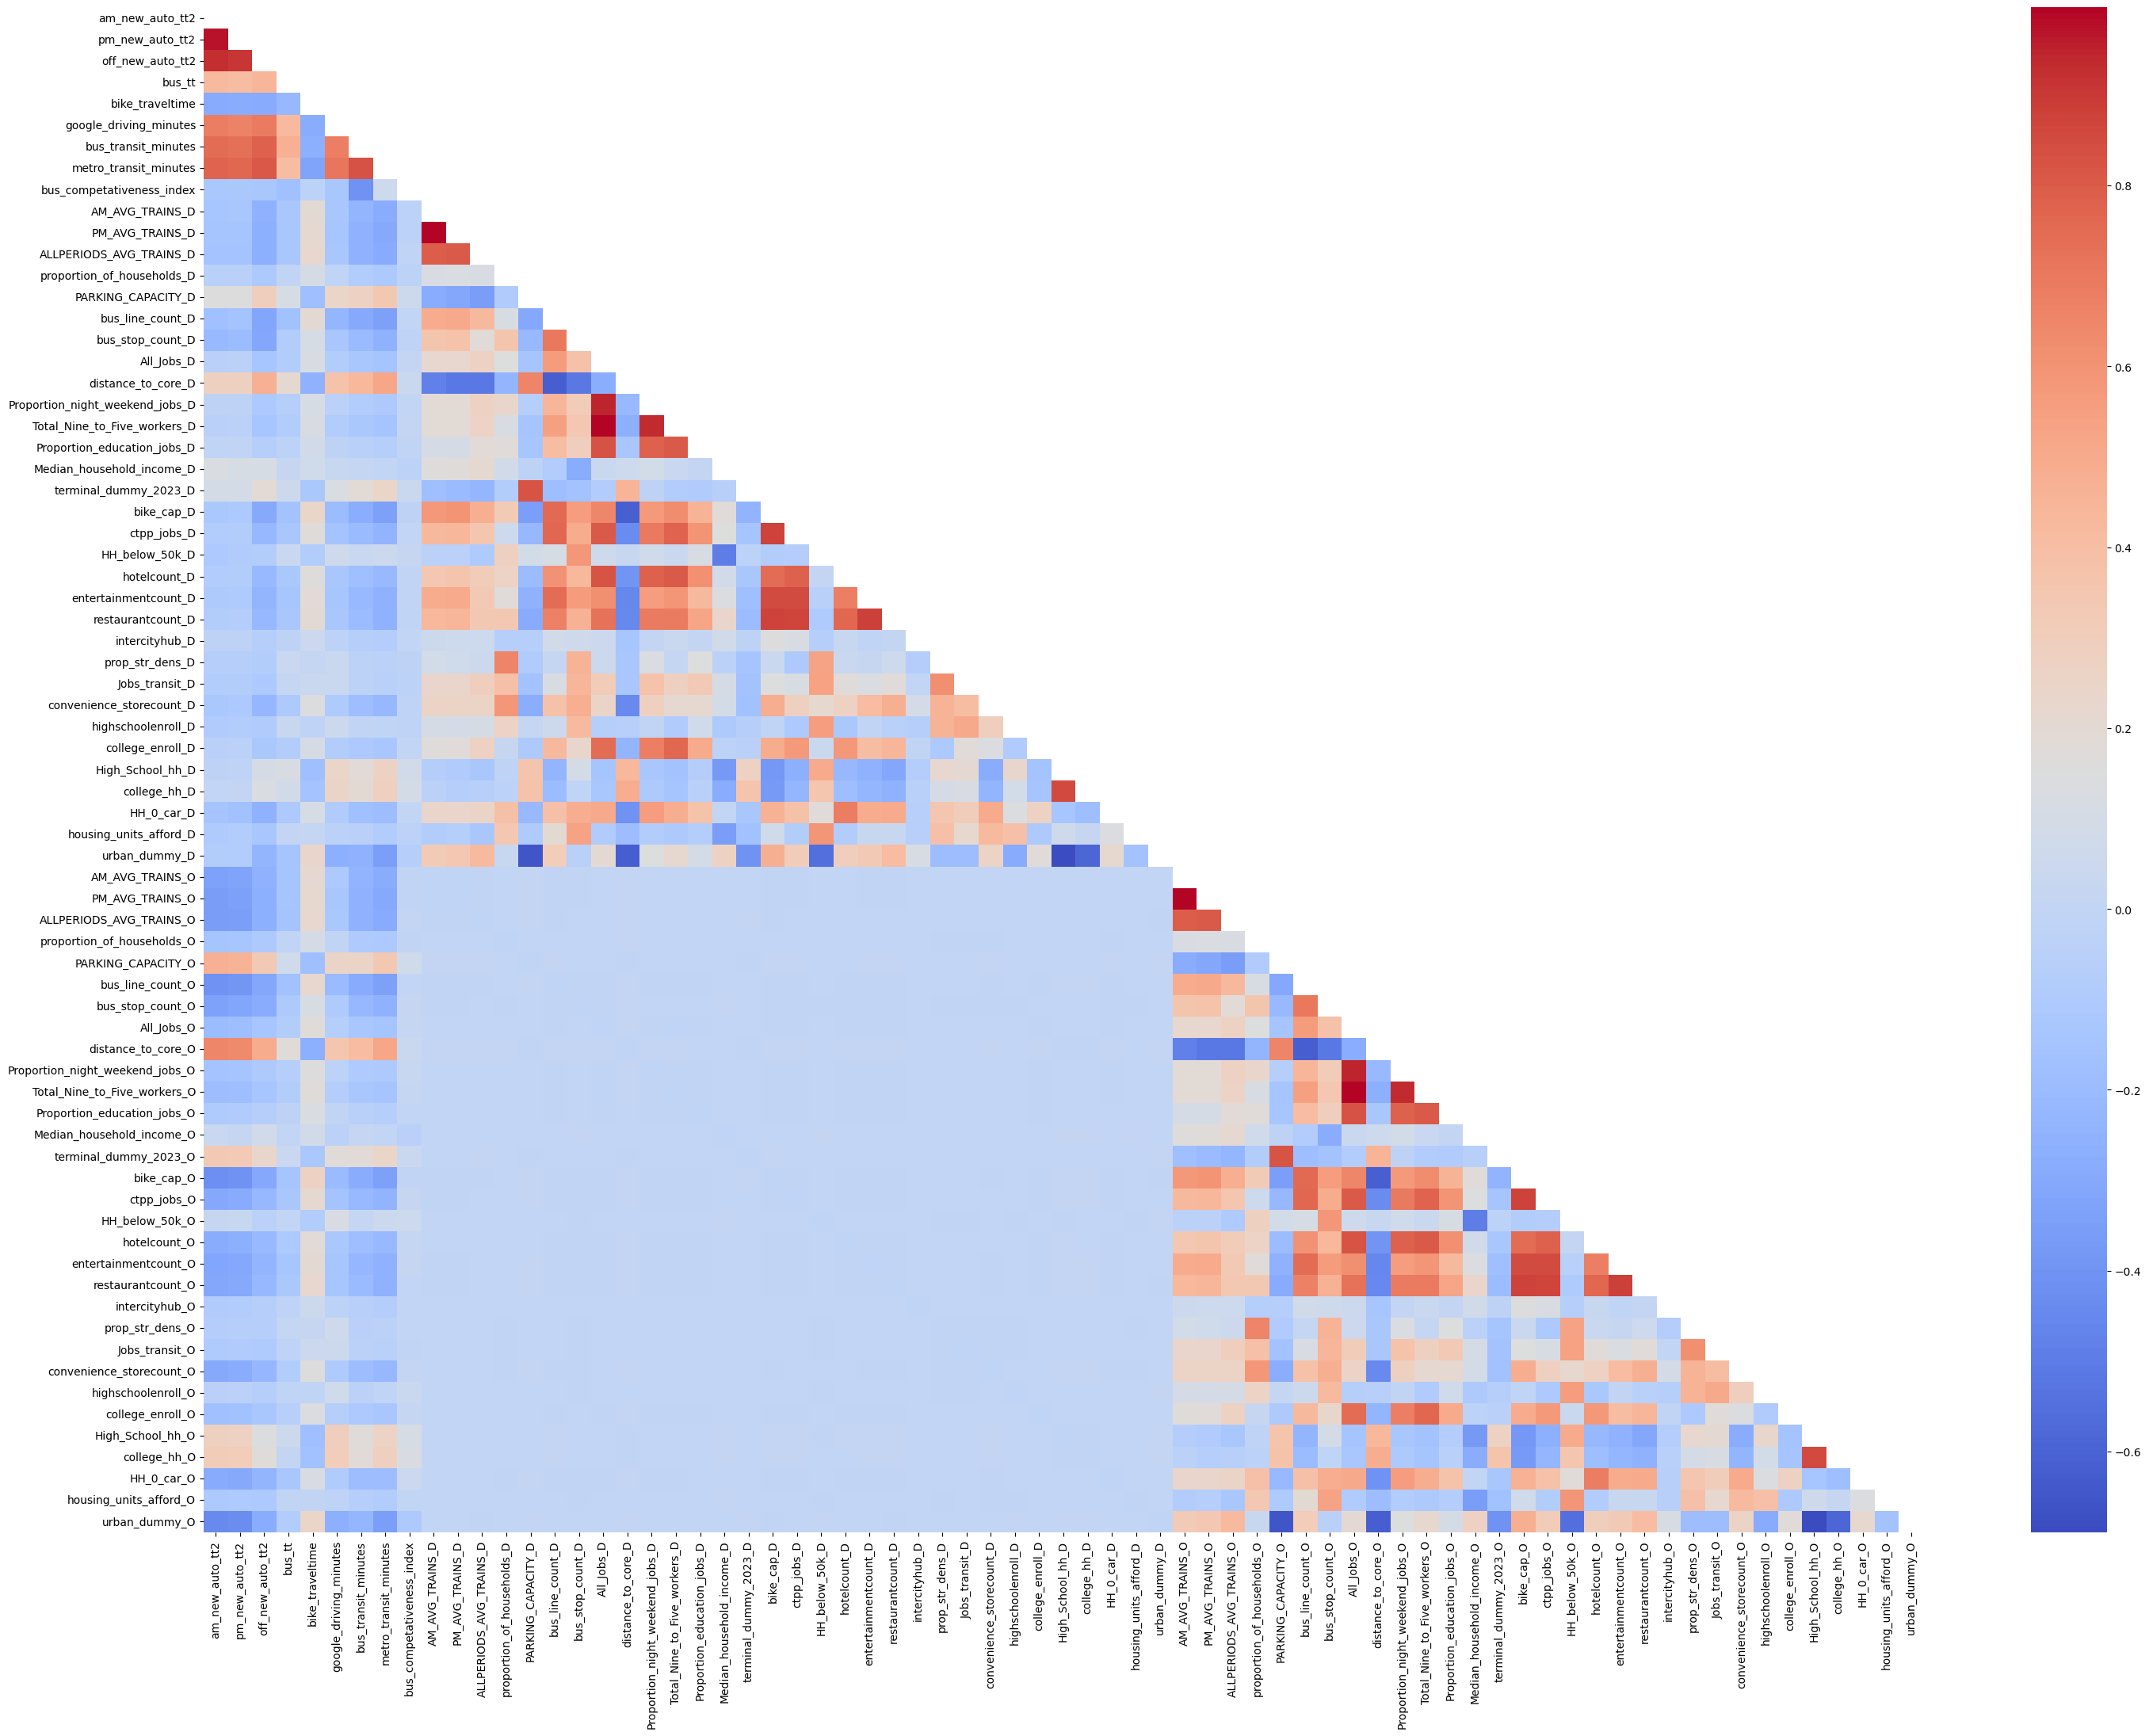

In [16]:
plt.figure(figsize=(35, 25))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', cbar=True)
plt.savefig('corr_mat.png')
plt.show()

In [17]:
mask = (corr_matrix > 0.9) & (corr_matrix < 1)
pairs = corr_matrix[mask].stack().reset_index()
pairs.columns = ['Variable1', 'Variable2', 'Correlation']
pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

,Variable1,Variable2,Correlation
0,PM_AVG_TRAINS_O,AM_AVG_TRAINS_O,0.997030
1,AM_AVG_TRAINS_O,PM_AVG_TRAINS_O,0.997030
2,AM_AVG_TRAINS_D,PM_AVG_TRAINS_D,0.997030
3,PM_AVG_TRAINS_D,AM_AVG_TRAINS_D,0.997030
4,Total_Nine_to_Five_workers_O,All_Jobs_O,0.992929
5,All_Jobs_O,Total_Nine_to_Five_workers_O,0.992929
6,All_Jobs_D,Total_Nine_to_Five_workers_D,0.992915
7,Total_Nine_to_Five_workers_D,All_Jobs_D,0.992915
8,am_new_auto_tt2,pm_new_auto_tt2,0.972488
9,pm_new_auto_tt2,am_new_auto_tt2,0.972488


### VIFs

In [18]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

In [19]:
# simple_imputer = SimpleImputer(strategy='median')
# knn_imputer = KNNImputer(n_neighbors=100, weights="uniform")

# X_simple_imputed = simple_imputer.fit_transform(X)
# X_knn_imputed = knn_imputer.fit_transform(X)

In [20]:
# df_X_knn = pd.DataFrame(X_knn_imputed, columns=X.columns)

In [21]:
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# vif_data["VIF"] = vif_data["VIF"].astype('float')
# vif_data = vif_data.sort_values(by='VIF').reset_index(drop=True)
# vif_data["VIF"] = vif_data["VIF"].astype('str')
# vif_data

In [22]:
X.shape

(8187, 71)

## Individual Urban Category variables correlation check

### Jobs

In [23]:
jobs = OD.copy()

In [24]:
jobs.head()

,passengers,am_new_auto_tt2,pm_new_auto_tt2,off_new_auto_tt2,bus_tt,bike_traveltime,google_driving_minutes,bus_transit_minutes,metro_transit_minutes,bus_competativeness_index,AM_AVG_TRAINS_D,PM_AVG_TRAINS_D,ALLPERIODS_AVG_TRAINS_D,proportion_of_households_D,PARKING_CAPACITY_D,bus_line_count_D,bus_stop_count_D,All_Jobs_D,distance_to_core_D,Proportion_night_weekend_jobs_D,Total_Nine_to_Five_workers_D,Proportion_education_jobs_D,Median_household_income_D,terminal_dummy_2023_D,bike_cap_D,ctpp_jobs_D,HH_below_50k_D,hotelcount_D,entertainmentcount_D,restaurantcount_D,intercityhub_D,prop_str_dens_D,Jobs_transit_D,convenience_storecount_D,highschoolenroll_D,college_enroll_D,High_School_hh_D,college_hh_D,HH_0_car_D,housing_units_afford_D,urban_dummy_D,AM_AVG_TRAINS_O,PM_AVG_TRAINS_O,ALLPERIODS_AVG_TRAINS_O,proportion_of_households_O,PARKING_CAPACITY_O,bus_line_count_O,bus_stop_count_O,All_Jobs_O,distance_to_core_O,Proportion_night_weekend_jobs_O,Total_Nine_to_Five_workers_O,Proportion_education_jobs_O,Median_household_income_O,terminal_dummy_2023_O,bike_cap_O,ctpp_jobs_O,HH_below_50k_O,hotelcount_O,entertainmentcount_O,restaurantcount_O,intercityhub_O,prop_str_dens_O,Jobs_transit_O,convenience_storecount_O,highschoolenroll_O,college_enroll_O,High_School_hh_O,college_hh_O,HH_0_car_O,housing_units_afford_O,urban_dummy_O
0,1418,13.160672,13.212824,9.632492,31.0,22.166667,9.95,34.02,9,0.264550,62,62,6.340909,2.214692,NaN,86,50,0.000000,0.435964,0.000000,0.000000,0.000000,135011.0,0,324.0,56593.758076,548.4,4.0,8.0,76.0,NaN,170.832426,13524248,1.0,728.0,NaN,NaN,NaN,0.0,214.0,1,33,34,3.4,5.065567,808.0,69,75,8900.0922,3.007895,410.559374,3862.041572,607.720656,32458.0,0,71.0,7254.574071,5447.9,NaN,NaN,8.0,40970.0,383.409456,103249729,7.0,3634.0,NaN,NaN,NaN,8.0,4013.0,0
1,156,23.147509,23.128796,16.366593,44.0,NaN,12.58,54.20,26,0.479705,51,48,5.318182,3.304806,NaN,30,34,1301.516260,4.917774,309.339252,171.855140,325.379065,52158.0,0,19.0,891.511477,2995.5,NaN,NaN,1.0,23432.0,670.688026,78475113,1.0,752.0,NaN,NaN,NaN,15.5,258.0,1,33,34,3.4,5.065567,808.0,69,75,8900.0922,3.007895,410.559374,3862.041572,607.720656,32458.0,0,71.0,7254.574071,5447.9,NaN,NaN,8.0,40970.0,383.409456,103249729,7.0,3634.0,NaN,NaN,NaN,8.0,4013.0,0
2,425,21.606200,21.598424,15.327292,79.0,NaN,19.05,65.25,27,0.413793,56,53,5.311111,1.958217,NaN,28,37,6927.087249,3.037076,2096.355352,1209.350277,2007.432537,105813.5,0,94.0,2231.157947,1303.8,NaN,4.0,10.0,NaN,423.562722,84269617,1.0,910.0,5790.0,NaN,NaN,21.0,407.0,1,33,34,3.4,5.065567,808.0,69,75,8900.0922,3.007895,410.559374,3862.041572,607.720656,32458.0,0,71.0,7254.574071,5447.9,NaN,NaN,8.0,40970.0,383.409456,103249729,7.0,3634.0,NaN,NaN,NaN,8.0,4013.0,0
3,146,13.899656,13.946564,10.130787,25.0,11.683333,7.92,28.82,16,0.555170,78,74,8.186047,4.035046,NaN,25,16,8956.830912,1.482361,2992.228186,2563.956664,411.254111,141971.5,0,137.0,14219.566557,1035.8,1.0,1.0,17.0,79204.0,208.598265,92085891,1.0,433.0,NaN,NaN,NaN,17.0,NaN,1,33,34,3.4,5.065567,808.0,69,75,8900.0922,3.007895,410.559374,3862.041572,607.720656,32458.0,0,71.0,7254.574071,5447.9,NaN,NaN,8.0,40970.0,383.409456,103249729,7.0,3634.0,NaN,NaN,NaN,8.0,4013.0,0
4,124,21.205038,21.200108,15.056789,78.0,NaN,24.62,74.78,28,0.374432,56,53,5.666667,4.764639,NaN,18,20,910.988507,3.076134,335.627345,134.961260,5.327418,114540.0,0,41.0,2352.866220,483.9,NaN,1.0,16.0,47161.0,268.297931,46701329,1.0,NaN,NaN,NaN,NaN,22.0,NaN,1,33,34,3.4,5.065567,808.0,69,75,8900.0922,3.007895,410.559374,3862.041572,607.720656,32458.0,0,71.0,7254.574071,5447.9,NaN,NaN,8.0,40970.0,383.409456,103249729,7.0,3634.0,NaN,NaN,NaN,8.0,4013.0,0


In [25]:
# jobs = jobs[['All_Jobs_O', 'All_Jobs_D', 'ctpp_jobs_O', 'ctpp_jobs_D', 'Proportion_education_jobs_O', 
#            'Proportion_education_jobs_D', 'Total_Nine_to_Five_workers_O', 'Total_Nine_to_Five_workers_D', 
#           'Proportion_night_weekend_jobs_O', 'Proportion_night_weekend_jobs_D']]


jobs = jobs[['Total_Nine_to_Five_workers_O', 'Total_Nine_to_Five_workers_D', 'Proportion_education_jobs_O', 'Proportion_education_jobs_D',
          'Proportion_night_weekend_jobs_O', 'Proportion_night_weekend_jobs_D']]

jobs_corr = jobs.corr()
jobs_corr

,Total_Nine_to_Five_workers_O,Total_Nine_to_Five_workers_D,Proportion_education_jobs_O,Proportion_education_jobs_D,Proportion_night_weekend_jobs_O,Proportion_night_weekend_jobs_D
Total_Nine_to_Five_workers_O,1.000000,-0.011135,0.804695,-0.008962,0.933642,-0.010415
Total_Nine_to_Five_workers_D,-0.011135,1.000000,-0.008833,0.803965,-0.010386,0.933603
Proportion_education_jobs_O,0.804695,-0.008833,1.000000,-0.010995,0.780601,-0.008474
Proportion_education_jobs_D,-0.008962,0.803965,-0.010995,1.000000,-0.008685,0.780244
Proportion_night_weekend_jobs_O,0.933642,-0.010386,0.780601,-0.008685,1.000000,-0.011128
Proportion_night_weekend_jobs_D,-0.010415,0.933603,-0.008474,0.780244,-0.011128,1.000000


In [26]:
job_mask = (jobs_corr > 0.7) & (jobs_corr < 1)
job_pairs = jobs_corr[job_mask].stack().reset_index()
job_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
job_pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

,Variable1,Variable2,Correlation
0,Total_Nine_to_Five_workers_O,Proportion_night_weekend_jobs_O,0.933642
1,Proportion_night_weekend_jobs_O,Total_Nine_to_Five_workers_O,0.933642
2,Total_Nine_to_Five_workers_D,Proportion_night_weekend_jobs_D,0.933603
3,Proportion_night_weekend_jobs_D,Total_Nine_to_Five_workers_D,0.933603
4,Total_Nine_to_Five_workers_O,Proportion_education_jobs_O,0.804695
5,Proportion_education_jobs_O,Total_Nine_to_Five_workers_O,0.804695
6,Total_Nine_to_Five_workers_D,Proportion_education_jobs_D,0.803965
7,Proportion_education_jobs_D,Total_Nine_to_Five_workers_D,0.803965
8,Proportion_education_jobs_O,Proportion_night_weekend_jobs_O,0.780601
9,Proportion_night_weekend_jobs_O,Proportion_education_jobs_O,0.780601


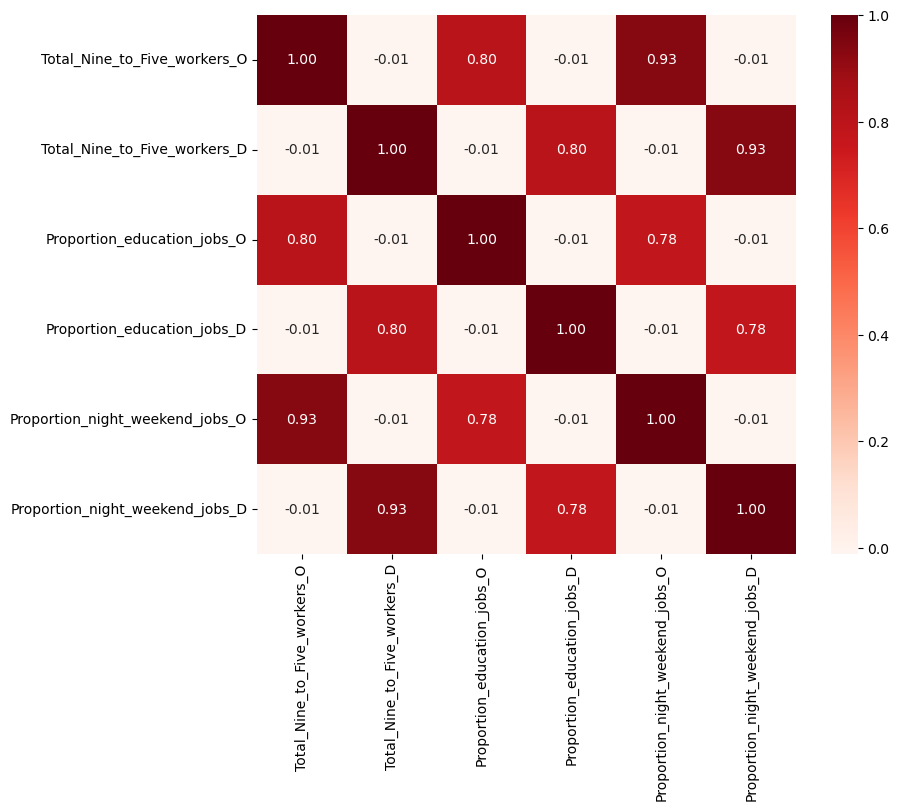

In [27]:
plt.figure(figsize=(9, 7))
sns.heatmap(jobs_corr, annot=True, fmt='.2f', cmap='Reds', square=True)
plt.show()

### Operational Efficiency

In [28]:
avg_trains = OD.copy()

In [29]:
avg_trains = avg_trains[['AM_AVG_TRAINS_O', 'AM_AVG_TRAINS_D', 'PM_AVG_TRAINS_O', 'PM_AVG_TRAINS_D', 'ALLPERIODS_AVG_TRAINS_O', 
           'ALLPERIODS_AVG_TRAINS_D',]]

avg_trains_corr = avg_trains.corr()
avg_trains_corr

,AM_AVG_TRAINS_O,AM_AVG_TRAINS_D,PM_AVG_TRAINS_O,PM_AVG_TRAINS_D,ALLPERIODS_AVG_TRAINS_O,ALLPERIODS_AVG_TRAINS_D
AM_AVG_TRAINS_O,1.000000,-0.011475,0.997030,-0.011436,0.799268,-0.009333
AM_AVG_TRAINS_D,-0.011475,1.000000,-0.011444,0.997030,-0.009279,0.799228
PM_AVG_TRAINS_O,0.997030,-0.011444,1.000000,-0.011468,0.803722,-0.009383
PM_AVG_TRAINS_D,-0.011436,0.997030,-0.011468,1.000000,-0.009324,0.803682
ALLPERIODS_AVG_TRAINS_O,0.799268,-0.009279,0.803722,-0.009324,1.000000,-0.011608
ALLPERIODS_AVG_TRAINS_D,-0.009333,0.799228,-0.009383,0.803682,-0.011608,1.000000


In [30]:
avg_trains_mask = (avg_trains_corr > 0.7) & (avg_trains_corr < 1)
avg_trains_pairs = avg_trains_corr[avg_trains_mask].stack().reset_index()
avg_trains_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
avg_trains_pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

,Variable1,Variable2,Correlation
0,AM_AVG_TRAINS_O,PM_AVG_TRAINS_O,0.997030
1,PM_AVG_TRAINS_O,AM_AVG_TRAINS_O,0.997030
2,AM_AVG_TRAINS_D,PM_AVG_TRAINS_D,0.997030
3,PM_AVG_TRAINS_D,AM_AVG_TRAINS_D,0.997030
4,PM_AVG_TRAINS_O,ALLPERIODS_AVG_TRAINS_O,0.803722
5,ALLPERIODS_AVG_TRAINS_O,PM_AVG_TRAINS_O,0.803722
6,PM_AVG_TRAINS_D,ALLPERIODS_AVG_TRAINS_D,0.803682
7,ALLPERIODS_AVG_TRAINS_D,PM_AVG_TRAINS_D,0.803682
8,AM_AVG_TRAINS_O,ALLPERIODS_AVG_TRAINS_O,0.799268
9,ALLPERIODS_AVG_TRAINS_O,AM_AVG_TRAINS_O,0.799268


#### calculate VIFs

In [31]:
def calculate_vif(var_name):
    vif_data = pd.DataFrame()
    vif_data['feature'] = var_name.columns
    knn_imputer = KNNImputer(n_neighbors=100, weights="uniform")
    var_knn_imputed = knn_imputer.fit_transform(var_name)
    df = pd.DataFrame(var_knn_imputed, columns=var_name.columns)
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    vif_data["VIF"] = vif_data["VIF"].astype('float')
    vif_data = vif_data.sort_values(by='VIF').reset_index(drop=True)
    vif_data["VIF"] = vif_data["VIF"].astype('str')
    return vif_data
    
calculate_vif(avg_trains)

,feature,VIF
0,ALLPERIODS_AVG_TRAINS_D,26.41817326648776
1,ALLPERIODS_AVG_TRAINS_O,26.41850776895786
2,PM_AVG_TRAINS_O,1063.9284258209034
3,PM_AVG_TRAINS_D,1063.930083974983
4,AM_AVG_TRAINS_O,1119.1678417563435
5,AM_AVG_TRAINS_D,1119.2093261645803


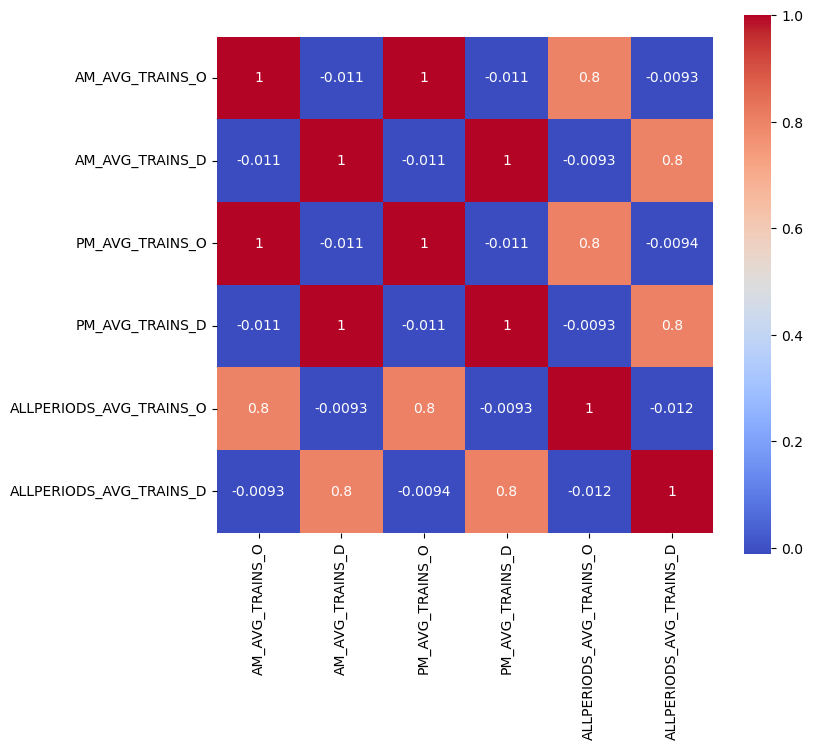

In [32]:
plt.figure(figsize=(8, 7))
sns.heatmap(avg_trains_corr, annot=True, cmap='coolwarm', square=True)
plt.show()

### Mode Competition

###### Auto Travel Time

In [33]:
auto_tt = OD.copy()

In [34]:
auto_tt = auto_tt[['am_new_auto_tt2', 'pm_new_auto_tt2', 'off_new_auto_tt2', 'google_driving_minutes']]

auto_tt_corr = auto_tt.corr()
auto_tt_corr

,am_new_auto_tt2,pm_new_auto_tt2,off_new_auto_tt2,google_driving_minutes
am_new_auto_tt2,1.000000,0.995063,0.927561,0.684434
pm_new_auto_tt2,0.995063,1.000000,0.928892,0.685467
off_new_auto_tt2,0.927561,0.928892,1.000000,0.692208
google_driving_minutes,0.684434,0.685467,0.692208,1.000000


In [35]:
auto_tt_mask = (auto_tt_corr > 0.5) & (auto_tt_corr < 1)
auto_tt_pairs = auto_tt_corr[auto_tt_mask].stack().reset_index()
auto_tt_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
auto_tt_pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

,Variable1,Variable2,Correlation
0,am_new_auto_tt2,pm_new_auto_tt2,0.995063
1,pm_new_auto_tt2,am_new_auto_tt2,0.995063
2,pm_new_auto_tt2,off_new_auto_tt2,0.928892
3,off_new_auto_tt2,pm_new_auto_tt2,0.928892
4,am_new_auto_tt2,off_new_auto_tt2,0.927561
5,off_new_auto_tt2,am_new_auto_tt2,0.927561
6,off_new_auto_tt2,google_driving_minutes,0.692208
7,google_driving_minutes,off_new_auto_tt2,0.692208
8,pm_new_auto_tt2,google_driving_minutes,0.685467
9,google_driving_minutes,pm_new_auto_tt2,0.685467


###### calculate VIFs

In [36]:
calculate_vif(auto_tt)

,feature,VIF
0,google_driving_minutes,8.975572880993068
1,off_new_auto_tt2,35.021228036742905
2,am_new_auto_tt2,430.0346023187406
3,pm_new_auto_tt2,437.1898112245172


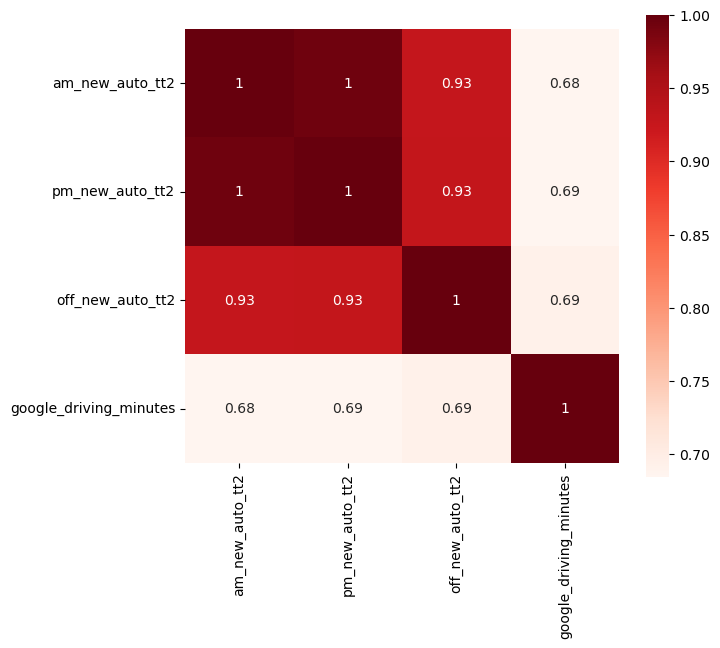

In [37]:
plt.figure(figsize=(7, 6))
sns.heatmap(auto_tt_corr, annot=True, cmap='Reds', square=True)
plt.show()

###### Bus Travel Time

In [38]:
bus_tt = OD.copy()

In [39]:
bus_tt = bus_tt[['bus_tt', 'bus_transit_minutes']]

bus_tt_corr = bus_tt.corr()
bus_tt_corr

,bus_tt,bus_transit_minutes
bus_tt,1.0000,0.7888
bus_transit_minutes,0.7888,1.0000


In [40]:
bus_tt_mask = (bus_tt_corr > 0.5) & (bus_tt_corr < 1)
bus_tt_pairs = bus_tt_corr[bus_tt_mask].stack().reset_index()
bus_tt_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
bus_tt_pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

,Variable1,Variable2,Correlation
0,bus_tt,bus_transit_minutes,0.7888
1,bus_transit_minutes,bus_tt,0.7888


###### calculate VIFs

In [41]:
calculate_vif(bus_tt)

,feature,VIF
0,bus_tt,11.722337468452631
1,bus_transit_minutes,11.722337468452631


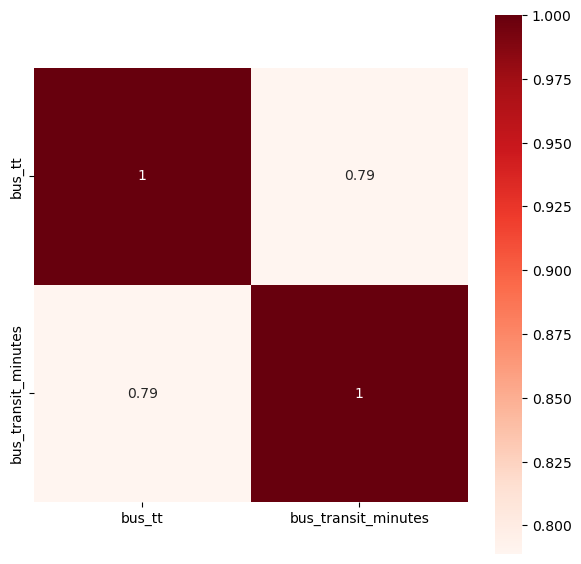

In [42]:
plt.figure(figsize=(7, 7))
sns.heatmap(bus_tt_corr, annot=True, cmap='Reds', square=True)
plt.show()

##### Mode Competition general

In [43]:
mode = OD.copy()

In [44]:
mode = mode[['bike_traveltime', 'metro_transit_minutes', 'bus_tt', 'bus_transit_minutes', 'am_new_auto_tt2', 
             'pm_new_auto_tt2', 'off_new_auto_tt2', 'google_driving_minutes', 'bus_competativeness_index']]

mode_corr = mode.corr()
mode_corr

,bike_traveltime,metro_transit_minutes,bus_tt,bus_transit_minutes,am_new_auto_tt2,pm_new_auto_tt2,off_new_auto_tt2,google_driving_minutes,bus_competativeness_index
bike_traveltime,1.000000,0.419082,0.528281,0.492948,0.495914,0.494265,0.520398,0.478652,-0.082387
metro_transit_minutes,0.419082,1.000000,0.771157,0.832776,0.777128,0.773858,0.811054,0.709460,0.056576
bus_tt,0.528281,0.771157,1.000000,0.788800,0.801627,0.801922,0.854008,0.663466,-0.159577
bus_transit_minutes,0.492948,0.832776,0.788800,1.000000,0.749714,0.749927,0.783928,0.684043,-0.415168
am_new_auto_tt2,0.495914,0.777128,0.801627,0.749714,1.000000,0.995063,0.927561,0.684434,-0.122125
pm_new_auto_tt2,0.494265,0.773858,0.801922,0.749927,0.995063,1.000000,0.928892,0.685467,-0.131645
off_new_auto_tt2,0.520398,0.811054,0.854008,0.783928,0.927561,0.928892,1.000000,0.692208,-0.135256
google_driving_minutes,0.478652,0.709460,0.663466,0.684043,0.684434,0.685467,0.692208,1.000000,-0.126467
bus_competativeness_index,-0.082387,0.056576,-0.159577,-0.415168,-0.122125,-0.131645,-0.135256,-0.126467,1.000000


In [45]:
mode_mask = (mode_corr > 0.1) & (mode_corr < 1)
mode_pairs = mode_corr[mode_mask].stack().reset_index()
mode_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
mode_pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

,Variable1,Variable2,Correlation
0,pm_new_auto_tt2,am_new_auto_tt2,0.995063
1,am_new_auto_tt2,pm_new_auto_tt2,0.995063
2,pm_new_auto_tt2,off_new_auto_tt2,0.928892
3,off_new_auto_tt2,pm_new_auto_tt2,0.928892
4,am_new_auto_tt2,off_new_auto_tt2,0.927561
5,off_new_auto_tt2,am_new_auto_tt2,0.927561
6,off_new_auto_tt2,bus_tt,0.854008
7,bus_tt,off_new_auto_tt2,0.854008
8,metro_transit_minutes,bus_transit_minutes,0.832776
9,bus_transit_minutes,metro_transit_minutes,0.832776


###### calculate VIFs

In [46]:
calculate_vif(mode)

,feature,VIF
0,bus_competativeness_index,7.5686130883407134
1,bike_traveltime,16.652522754044348
2,google_driving_minutes,16.73259427296259
3,bus_tt,23.28665437388679
4,bus_transit_minutes,29.747290739805102
5,metro_transit_minutes,35.60796274712652
6,off_new_auto_tt2,47.281224192908425
7,am_new_auto_tt2,410.278260186691
8,pm_new_auto_tt2,420.10163036027836


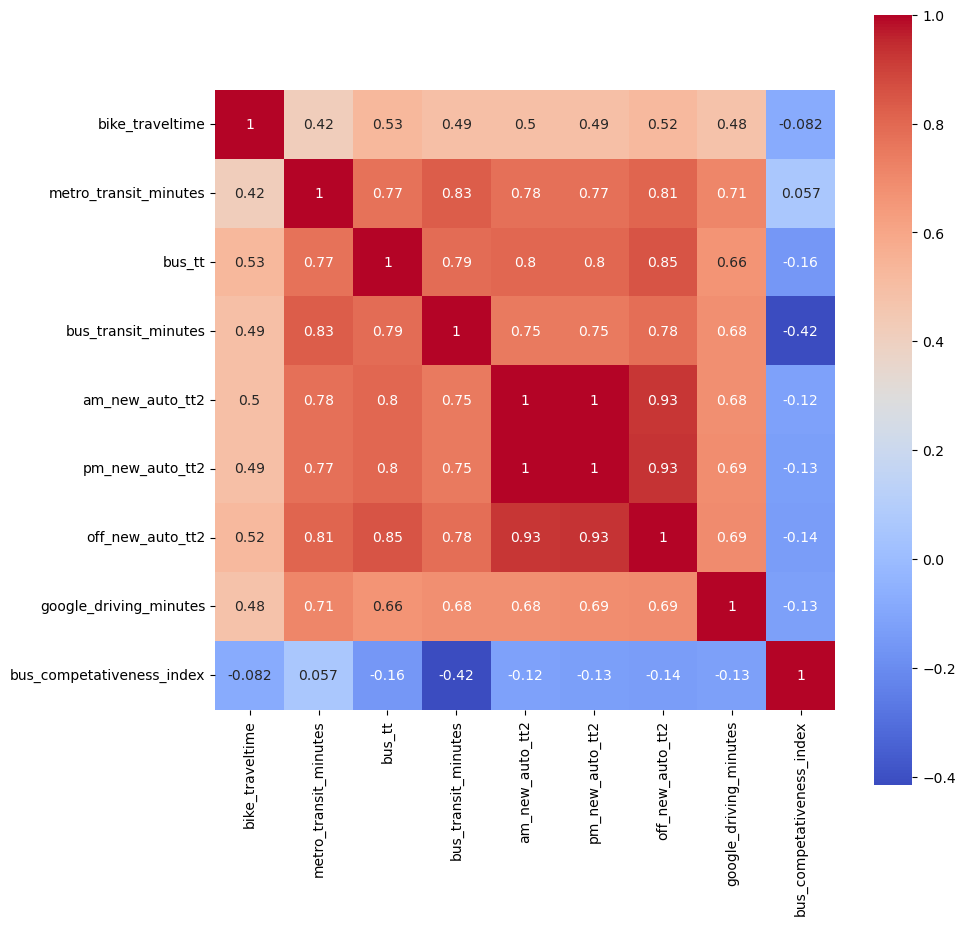

In [47]:
plt.figure(figsize=(10, 10))
sns.heatmap(mode_corr, annot=True, cmap='coolwarm', square=True)
plt.show()

### Education

In [48]:
edu = OD.copy()

In [49]:
edu = edu[['highschoolenroll_O', 'highschoolenroll_D', 'college_enroll_O', 'college_enroll_D', 'college_hh_O', 
          'college_hh_D', 'High_School_hh_O', 'High_School_hh_D']]

edu_corr = edu.corr()
edu_corr

,highschoolenroll_O,highschoolenroll_D,college_enroll_O,college_enroll_D,college_hh_O,college_hh_D,High_School_hh_O,High_School_hh_D
highschoolenroll_O,1.000000,-0.014874,-0.096809,0.002041,-0.055323,0.001336,0.315363,-0.004122
highschoolenroll_D,-0.014874,1.000000,0.002295,-0.096809,0.001276,-0.055048,-0.004292,0.315092
college_enroll_O,-0.096809,0.002295,1.000000,-0.041667,-0.810383,0.002037,-0.045739,0.000529
college_enroll_D,0.002041,-0.096809,-0.041667,1.000000,0.001751,-0.810383,0.000383,-0.045739
college_hh_O,-0.055323,0.001276,-0.810383,0.001751,1.000000,-0.034185,0.174000,-0.005845
college_hh_D,0.001336,-0.055048,0.002037,-0.810383,-0.034185,1.000000,-0.006012,0.173954
High_School_hh_O,0.315363,-0.004292,-0.045739,0.000383,0.174000,-0.006012,1.000000,-0.034489
High_School_hh_D,-0.004122,0.315092,0.000529,-0.045739,-0.005845,0.173954,-0.034489,1.000000


In [50]:
edu_mask = (edu_corr > 0.1) & (edu_corr < 1)
edu_pairs = edu_corr[edu_mask].stack().reset_index()
edu_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
edu_pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

,Variable1,Variable2,Correlation
0,highschoolenroll_O,High_School_hh_O,0.315363
1,High_School_hh_O,highschoolenroll_O,0.315363
2,highschoolenroll_D,High_School_hh_D,0.315092
3,High_School_hh_D,highschoolenroll_D,0.315092
4,college_hh_O,High_School_hh_O,0.174000
5,High_School_hh_O,college_hh_O,0.174000
6,college_hh_D,High_School_hh_D,0.173954
7,High_School_hh_D,college_hh_D,0.173954


#### calculate VIFs

In [51]:
calculate_vif(edu)

,feature,VIF
0,college_enroll_O,1.6488949512146236
1,college_enroll_D,1.6495454108327723
2,highschoolenroll_O,3.110729081903547
3,highschoolenroll_D,3.114881143508448
4,college_hh_D,12.605142260795713
5,college_hh_O,12.630468549885206
6,High_School_hh_O,17.520937846971457
7,High_School_hh_D,17.564962238532242


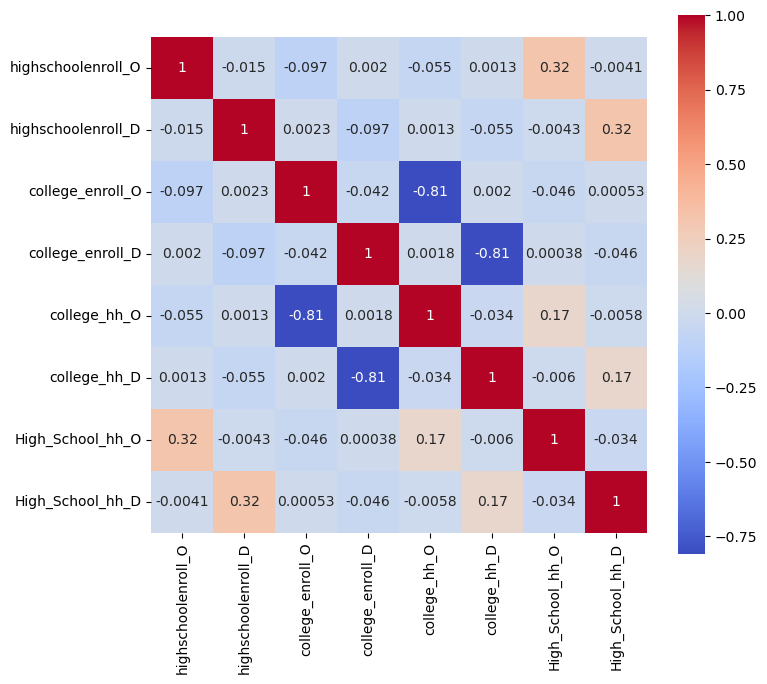

In [52]:
plt.figure(figsize=(8, 7))
sns.heatmap(edu_corr, annot=True, cmap='coolwarm', square=True)
plt.show()

### Amenities

In [53]:
amnts = OD.copy()

In [54]:
amnts = amnts[['entertainmentcount_O', 'entertainmentcount_D', 'restaurantcount_O', 'restaurantcount_D', 
               'convenience_storecount_O', 'convenience_storecount_D', 'hotelcount_O', 'hotelcount_D']]

amnts_corr = amnts.corr()
amnts_corr

,entertainmentcount_O,entertainmentcount_D,restaurantcount_O,restaurantcount_D,convenience_storecount_O,convenience_storecount_D,hotelcount_O,hotelcount_D
entertainmentcount_O,1.000000,-0.023256,0.862143,-0.012566,0.229709,-0.003932,0.566130,-0.013512
entertainmentcount_D,-0.023256,1.000000,-0.012566,0.862142,-0.003932,0.229815,-0.013512,0.566217
restaurantcount_O,0.862143,-0.012566,1.000000,-0.012658,0.331504,-0.004362,0.706650,-0.010978
restaurantcount_D,-0.012566,0.862142,-0.012658,1.000000,-0.004362,0.331509,-0.010978,0.706670
convenience_storecount_O,0.229709,-0.003932,0.331504,-0.004362,1.000000,-0.015385,0.156246,-0.002231
convenience_storecount_D,-0.003932,0.229815,-0.004362,0.331509,-0.015385,1.000000,-0.002231,0.156402
hotelcount_O,0.566130,-0.013512,0.706650,-0.010978,0.156246,-0.002231,1.000000,-0.027778
hotelcount_D,-0.013512,0.566217,-0.010978,0.706670,-0.002231,0.156402,-0.027778,1.000000


In [55]:
amnts_mask = (amnts_corr > 0.1) & (amnts_corr < 1)
amnts_pairs = amnts_corr[amnts_mask].stack().reset_index()
amnts_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
amnts_pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

,Variable1,Variable2,Correlation
0,entertainmentcount_O,restaurantcount_O,0.862143
1,restaurantcount_O,entertainmentcount_O,0.862143
2,entertainmentcount_D,restaurantcount_D,0.862142
3,restaurantcount_D,entertainmentcount_D,0.862142
4,restaurantcount_D,hotelcount_D,0.706670
5,hotelcount_D,restaurantcount_D,0.706670
6,restaurantcount_O,hotelcount_O,0.706650
7,hotelcount_O,restaurantcount_O,0.706650
8,entertainmentcount_D,hotelcount_D,0.566217
9,hotelcount_D,entertainmentcount_D,0.566217


#### calculate VIFs

In [56]:
calculate_vif(amnts)

,feature,VIF
0,convenience_storecount_O,2.456289697199366
1,convenience_storecount_D,2.4645152541742967
2,hotelcount_O,3.417844900508686
3,hotelcount_D,3.4373363583372707
4,entertainmentcount_O,6.8188494274634195
5,entertainmentcount_D,6.857574068456505
6,restaurantcount_O,8.675606190772754
7,restaurantcount_D,8.759626285109396


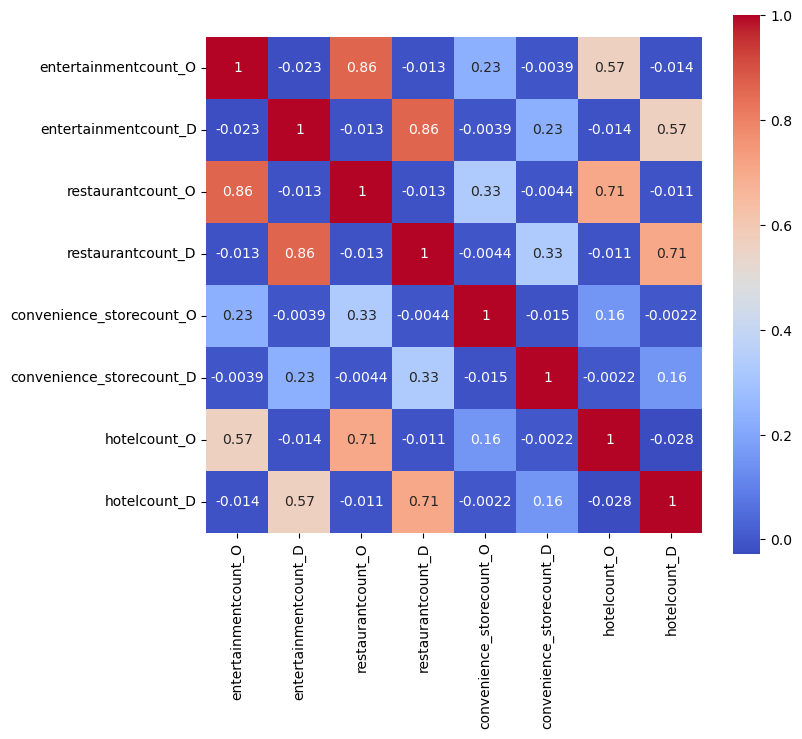

In [57]:
plt.figure(figsize=(8, 7))
sns.heatmap(amnts_corr, annot=True, cmap='coolwarm', square=True)
plt.show()

### Socio-Economic

In [58]:
socio = OD.copy()

In [59]:
socio = socio[['Median_household_income_O', 'Median_household_income_D', 'HH_below_50k_O', 'HH_below_50k_D', 
               'proportion_of_households_O', 'proportion_of_households_D', 'HH_0_car_O', 'HH_0_car_D']]

socio_corr = socio.corr()
socio_corr

,Median_household_income_O,Median_household_income_D,HH_below_50k_O,HH_below_50k_D,proportion_of_households_O,proportion_of_households_D,HH_0_car_O,HH_0_car_D
Median_household_income_O,1.000000,-0.011311,-0.637968,0.006898,-0.033074,0.000102,-0.063228,0.000551
Median_household_income_D,-0.011311,1.000000,0.007063,-0.637986,0.000189,-0.033177,0.000517,-0.063206
HH_below_50k_O,-0.637968,0.007063,1.000000,-0.011090,0.280229,-0.003098,0.179647,-0.001982
HH_below_50k_D,0.006898,-0.637986,-0.011090,1.000000,-0.003239,0.280312,-0.002019,0.179576
proportion_of_households_O,-0.033074,0.000189,0.280229,-0.003239,1.000000,-0.011496,0.384407,-0.004450
proportion_of_households_D,0.000102,-0.033177,-0.003098,0.280312,-0.011496,1.000000,-0.004499,0.384397
HH_0_car_O,-0.063228,0.000517,0.179647,-0.002019,0.384407,-0.004499,1.000000,-0.011200
HH_0_car_D,0.000551,-0.063206,-0.001982,0.179576,-0.004450,0.384397,-0.011200,1.000000


In [60]:
socio_mask = (socio_corr > 0.1) & (socio_corr < 1)
socio_pairs = socio_corr[socio_mask].stack().reset_index()
socio_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
socio_pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

,Variable1,Variable2,Correlation
0,proportion_of_households_O,HH_0_car_O,0.384407
1,HH_0_car_O,proportion_of_households_O,0.384407
2,proportion_of_households_D,HH_0_car_D,0.384397
3,HH_0_car_D,proportion_of_households_D,0.384397
4,HH_below_50k_D,proportion_of_households_D,0.280312
5,proportion_of_households_D,HH_below_50k_D,0.280312
6,HH_below_50k_O,proportion_of_households_O,0.280229
7,proportion_of_households_O,HH_below_50k_O,0.280229
8,HH_below_50k_O,HH_0_car_O,0.179647
9,HH_0_car_O,HH_below_50k_O,0.179647


#### calculate VIFs

In [61]:
calculate_vif(socio)

,feature,VIF
0,HH_0_car_D,1.9342096336266952
1,HH_0_car_O,1.9342980847293778
2,HH_below_50k_D,3.5759893324854386
3,HH_below_50k_O,3.5770163800796424
4,proportion_of_households_O,4.613623985591769
5,proportion_of_households_D,4.6140056335805095
6,Median_household_income_O,12.2710057001996
7,Median_household_income_D,12.271014500560659


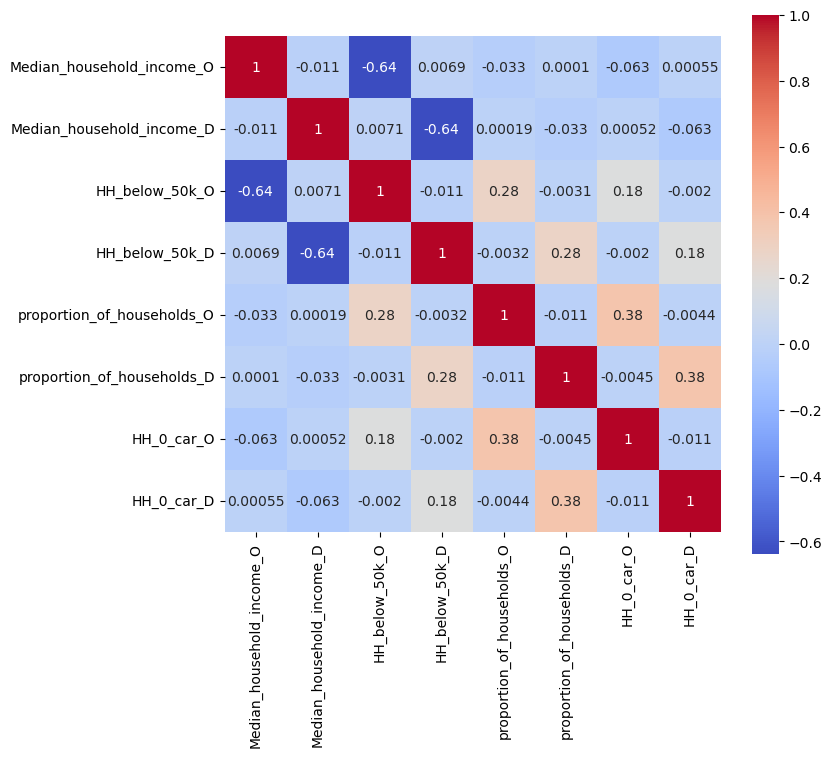

In [62]:
plt.figure(figsize=(8, 7))
sns.heatmap(socio_corr, annot=True, cmap='coolwarm', square=True)
plt.show()

### Transportation and Accessibility

In [63]:
trans = OD.copy()

In [64]:
trans = trans[['bike_cap_O', 'bike_cap_D', 'bus_stop_count_O', 'bus_stop_count_D', 'bus_line_count_O', 
               'bus_line_count_D', 'PARKING_CAPACITY_O', 'PARKING_CAPACITY_D', 'Jobs_transit_O', 
               'Jobs_transit_D', 'intercityhub_O', 'intercityhub_D']]

trans_corr = trans.corr()
trans_corr

,bike_cap_O,bike_cap_D,bus_stop_count_O,bus_stop_count_D,bus_line_count_O,bus_line_count_D,PARKING_CAPACITY_O,PARKING_CAPACITY_D,Jobs_transit_O,Jobs_transit_D,intercityhub_O,intercityhub_D
bike_cap_O,1.000000,-0.012821,0.574748,-0.006544,0.763766,-0.008803,-0.207664,-0.000050,0.078373,-0.000936,0.192103,-0.002321
bike_cap_D,-0.012821,1.000000,-0.006569,0.574703,-0.008837,0.763742,-0.000178,-0.207838,-0.000981,0.078180,-0.002342,0.192088
bus_stop_count_O,0.574748,-0.006569,1.000000,-0.011280,0.704339,-0.008016,-0.465151,0.005032,0.444211,-0.005172,0.078228,-0.000971
bus_stop_count_D,-0.006544,0.574703,-0.011280,1.000000,-0.008000,0.704336,0.005101,-0.465088,-0.005063,0.444074,-0.000953,0.078221
bus_line_count_O,0.763766,-0.008837,0.704339,-0.008000,1.000000,-0.011294,-0.366121,0.001989,0.126360,-0.001626,0.087071,-0.001103
bus_line_count_D,-0.008803,0.763742,-0.008016,0.704336,-0.011294,1.000000,0.002000,-0.366040,-0.001507,0.126198,-0.001092,0.087059
PARKING_CAPACITY_O,-0.207664,-0.000178,-0.465151,0.005101,-0.366121,0.002000,1.000000,-0.029101,-0.456357,0.005336,0.318213,-0.000527
PARKING_CAPACITY_D,-0.000050,-0.207838,0.005032,-0.465088,0.001989,-0.366040,-0.029101,1.000000,0.005779,-0.456750,-0.000491,0.318005
Jobs_transit_O,0.078373,-0.000981,0.444211,-0.005063,0.126360,-0.001507,-0.456357,0.005779,1.000000,-0.011226,-0.008118,0.000062
Jobs_transit_D,-0.000936,0.078180,-0.005172,0.444074,-0.001626,0.126198,0.005336,-0.456750,-0.011226,1.000000,0.000002,-0.008182


In [65]:
trans_mask = (trans_corr > 0.1) & (trans_corr < 1)
trans_pairs = trans_corr[trans_mask].stack().reset_index()
trans_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
trans_pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

,Variable1,Variable2,Correlation
0,bike_cap_O,bus_line_count_O,0.763766
1,bus_line_count_O,bike_cap_O,0.763766
2,bus_line_count_D,bike_cap_D,0.763742
3,bike_cap_D,bus_line_count_D,0.763742
4,bus_stop_count_O,bus_line_count_O,0.704339
5,bus_line_count_O,bus_stop_count_O,0.704339
6,bus_stop_count_D,bus_line_count_D,0.704336
7,bus_line_count_D,bus_stop_count_D,0.704336
8,bike_cap_O,bus_stop_count_O,0.574748
9,bus_stop_count_O,bike_cap_O,0.574748


#### calculate VIFs

In [66]:
calculate_vif(trans)

,feature,VIF
0,intercityhub_D,1.1460270292708679
1,intercityhub_O,1.146033488594375
2,Jobs_transit_D,3.6144982709618043
3,Jobs_transit_O,3.61570401939023
4,PARKING_CAPACITY_O,3.672367652399801
5,PARKING_CAPACITY_D,3.6737316738672083
6,bike_cap_D,5.085717175138999
7,bike_cap_O,5.085779196592064
8,bus_line_count_O,8.20480981315556
9,bus_line_count_D,8.205086105797855


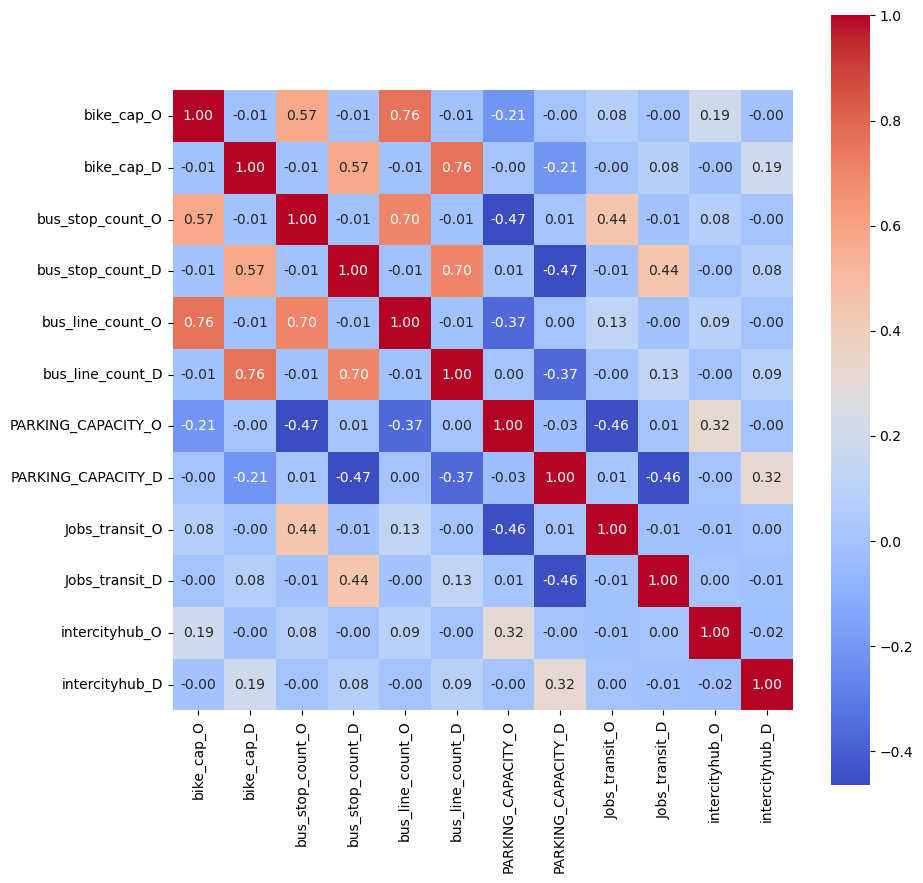

In [67]:
plt.figure(figsize=(10, 10))
sns.heatmap(trans_corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.show()

### Urban Form

In [68]:
form = OD.copy()

In [69]:
form = form[['distance_to_core_O', 'distance_to_core_D', 'prop_str_dens_O', 'prop_str_dens_D']]

form_corr = form.corr()
form_corr

,distance_to_core_O,distance_to_core_D,prop_str_dens_O,prop_str_dens_D
distance_to_core_O,1.000000,-0.011185,-0.128274,0.001575
distance_to_core_D,-0.011185,1.000000,0.001595,-0.128026
prop_str_dens_O,-0.128274,0.001595,1.000000,-0.011329
prop_str_dens_D,0.001575,-0.128026,-0.011329,1.000000


In [70]:
form_mask = (form_corr > -2) & (form_corr < 1)
form_pairs = form_corr[form_mask].stack().reset_index()
form_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
form_pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

,Variable1,Variable2,Correlation
0,distance_to_core_D,prop_str_dens_O,0.001595
1,prop_str_dens_O,distance_to_core_D,0.001595
2,distance_to_core_O,prop_str_dens_D,0.001575
3,prop_str_dens_D,distance_to_core_O,0.001575
4,distance_to_core_O,distance_to_core_D,-0.011185
5,distance_to_core_D,distance_to_core_O,-0.011185
6,prop_str_dens_O,prop_str_dens_D,-0.011329
7,prop_str_dens_D,prop_str_dens_O,-0.011329
8,distance_to_core_D,prop_str_dens_D,-0.128026
9,prop_str_dens_D,distance_to_core_D,-0.128026


#### calculate VIFs

In [71]:
calculate_vif(form)

,feature,VIF
0,prop_str_dens_O,1.8169460854735084
1,prop_str_dens_D,1.8172026630598554
2,distance_to_core_D,2.038929586544691
3,distance_to_core_O,2.038965169555336


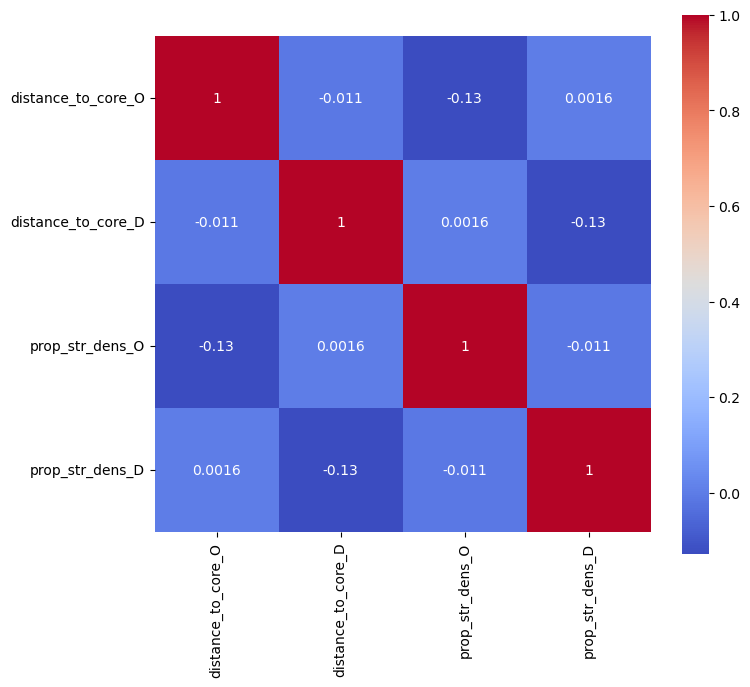

In [72]:
plt.figure(figsize=(8, 7))
sns.heatmap(form_corr, annot=True, cmap='coolwarm', square=True)
plt.show()

## Remove highly collinear variables

* xx of these variables were dropped and correlation and VIFs were recalculated (outdated)

In [73]:
# Xcorr = X.corr()
# plt.figure(figsize=(35, 30))
# sns.heatmap(Xcorr, cmap='coolwarm')

In [74]:
X1 = X.copy()

X1 = X1.drop(['All_Jobs_O', 'All_Jobs_D', 'ctpp_jobs_O', 'ctpp_jobs_D', 'urban_dummy_O', 'urban_dummy_D', 'terminal_dummy_2023_O', 
              'terminal_dummy_2023_D', 'AM_AVG_TRAINS_O',  'AM_AVG_TRAINS_D', 'PM_AVG_TRAINS_O', 'PM_AVG_TRAINS_D', 'am_new_auto_tt2', 
              'pm_new_auto_tt2', 'off_new_auto_tt2','bus_transit_minutes', ], axis=1)


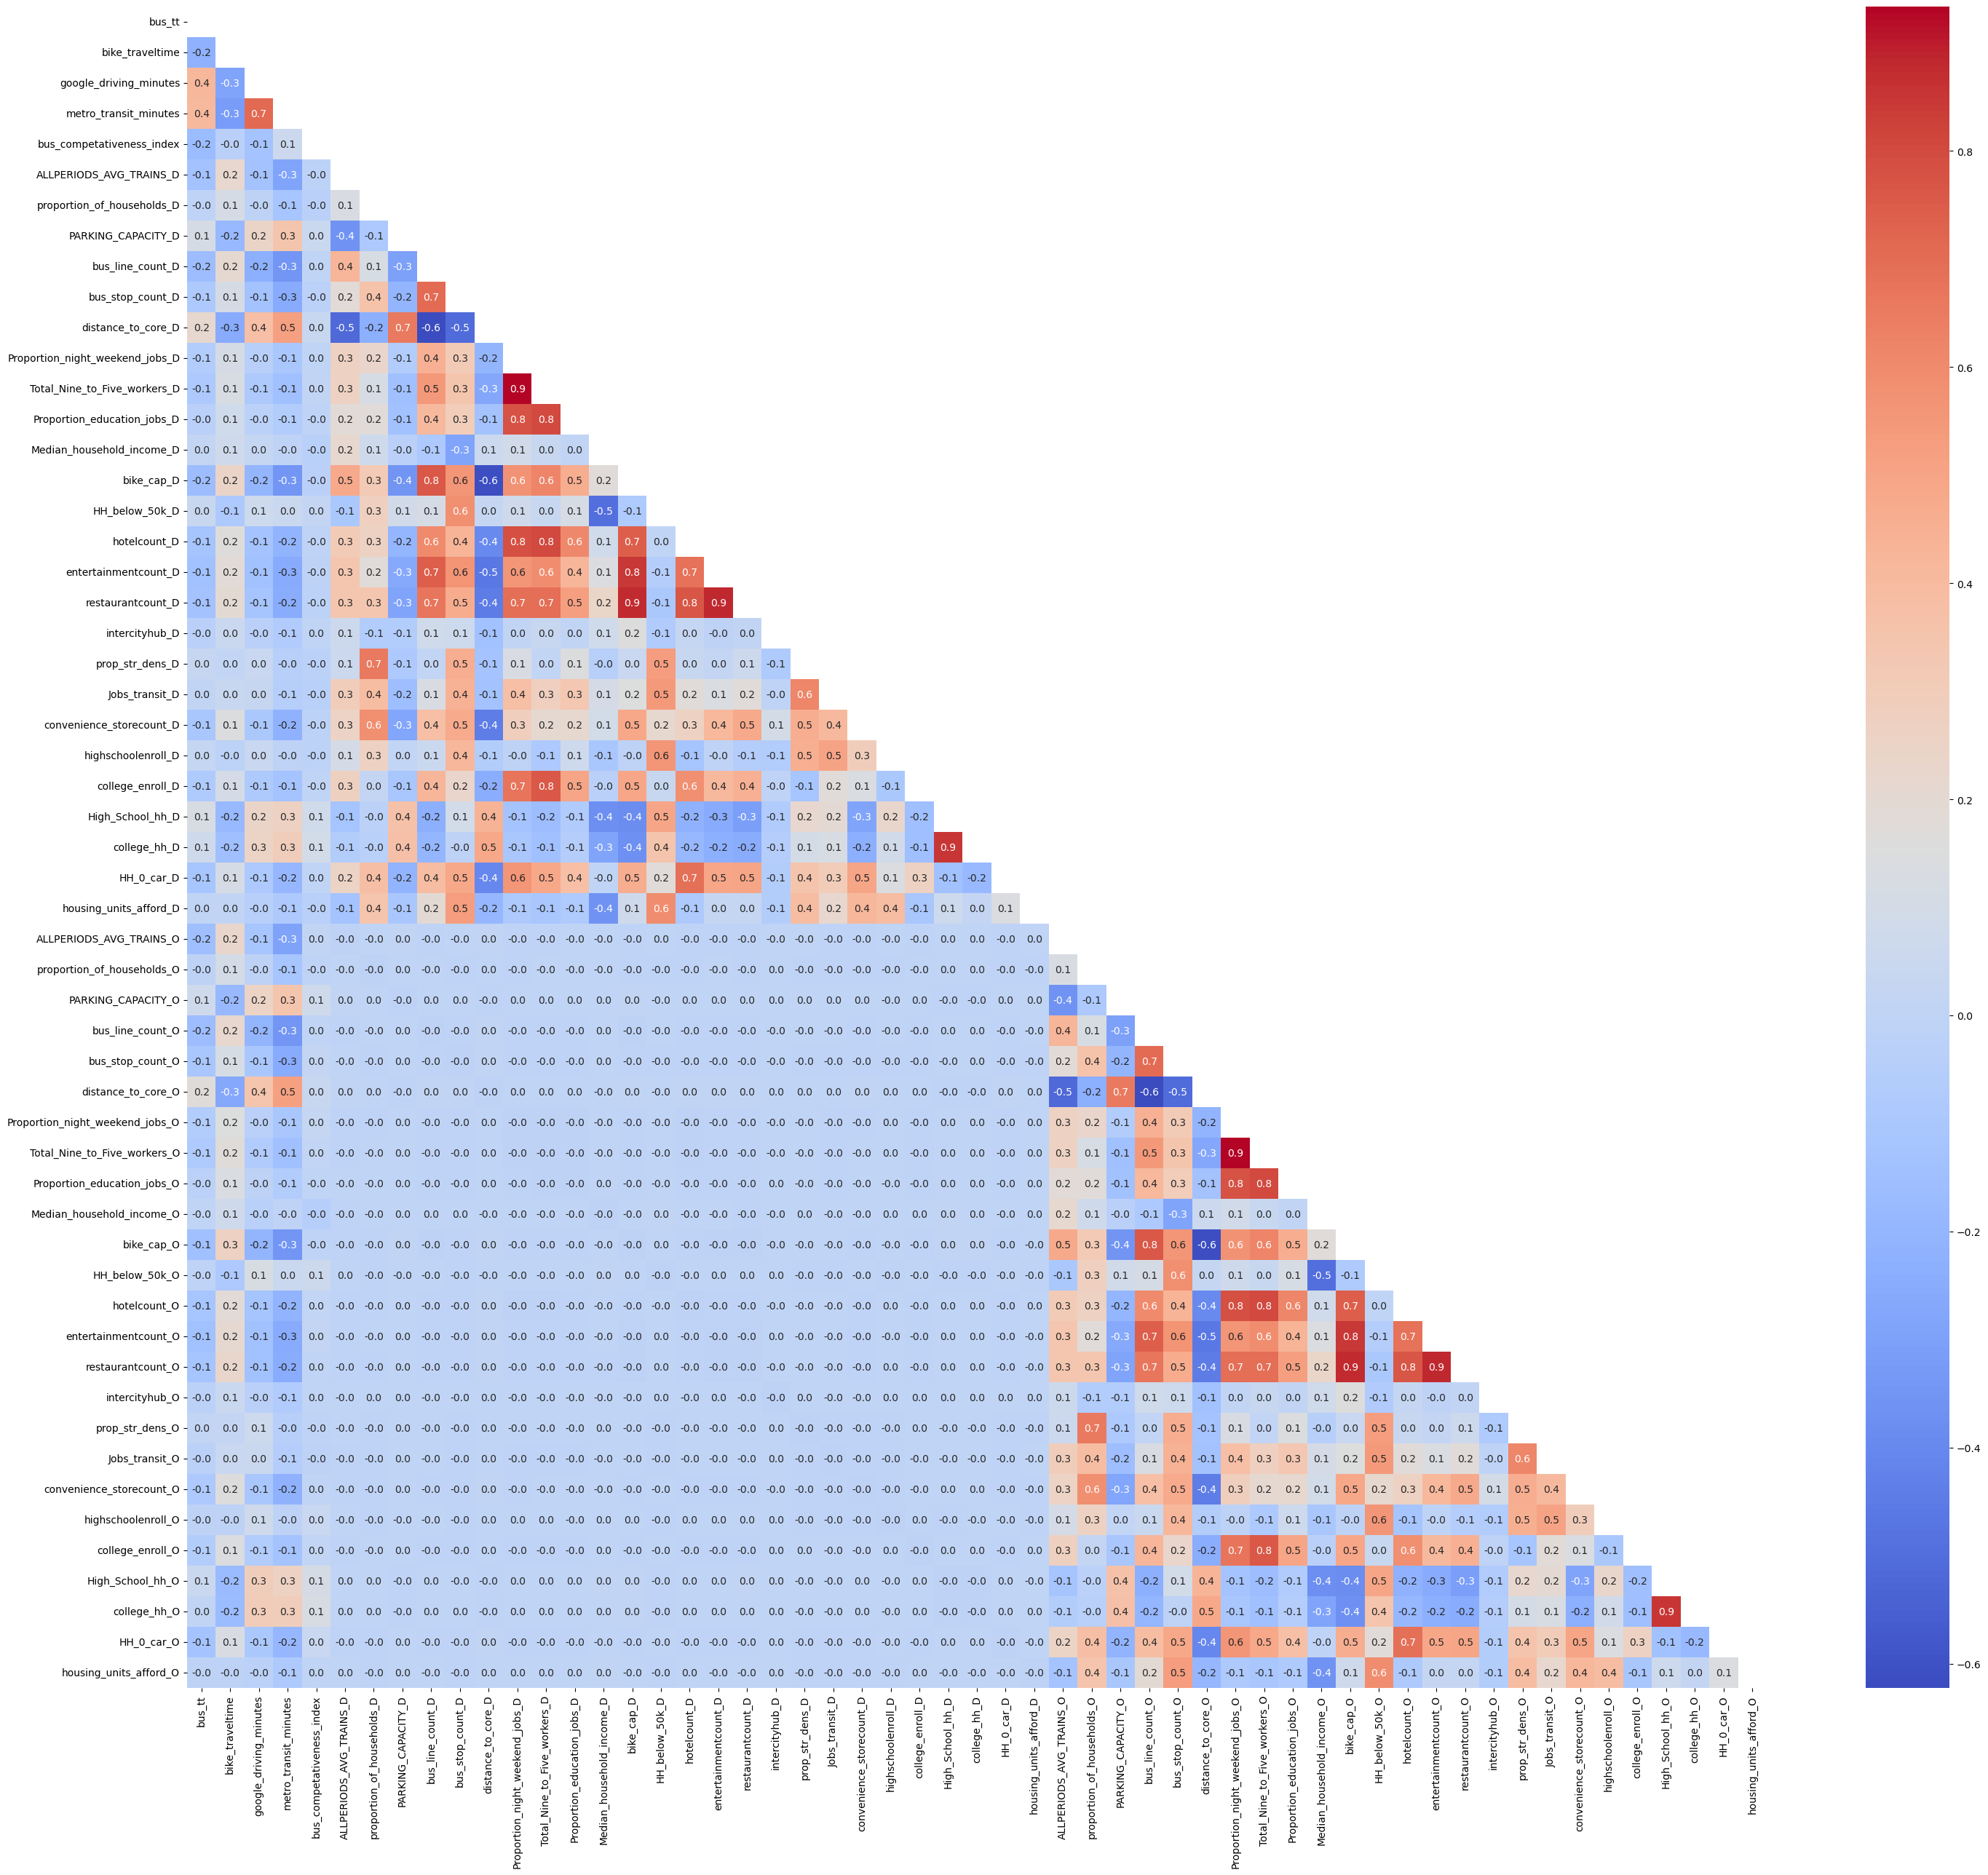

In [75]:
corr_matrix1 = X1.corr()
plt.figure(figsize=(35, 30))
mask1 = np.triu(np.ones_like(corr_matrix1, dtype=bool))
sns.heatmap(corr_matrix1, mask=mask1, annot=True, fmt='.1f', cmap='coolwarm', cbar=True)
plt.savefig('1corr_mat.png')
plt.show()

In [76]:
mask1 = (corr_matrix1 > 0.6) & (corr_matrix1 < 1)
pairs1 = corr_matrix[mask1].stack().reset_index()
pairs1.columns = ['Variable1', 'Variable2', 'Correlation']
pairs1.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

,Variable1,Variable2,Correlation
0,Total_Nine_to_Five_workers_O,Proportion_night_weekend_jobs_O,0.933642
1,Proportion_night_weekend_jobs_O,Total_Nine_to_Five_workers_O,0.933642
2,Proportion_night_weekend_jobs_D,Total_Nine_to_Five_workers_D,0.933603
3,Total_Nine_to_Five_workers_D,Proportion_night_weekend_jobs_D,0.933603
4,restaurantcount_O,entertainmentcount_O,0.884327
5,entertainmentcount_O,restaurantcount_O,0.884327
6,restaurantcount_D,entertainmentcount_D,0.884317
7,entertainmentcount_D,restaurantcount_D,0.884317
8,restaurantcount_O,bike_cap_O,0.875916
9,bike_cap_O,restaurantcount_O,0.875916


In [77]:
vif_data1 = pd.DataFrame()
vif_data1["feature"] = X1.columns

vif_data1["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(len(X1.columns))]

vif_data1["VIF"] = vif_data1["VIF"].astype('float')
vif_data1 = vif_data1.sort_values(by='VIF').reset_index(drop=True)
vif_data1["VIF"] = vif_data1["VIF"].astype('str')
vif_data1

,feature,VIF
0,bike_traveltime,1.4492085397521783
1,intercityhub_D,1.5078286062675847
2,intercityhub_O,1.5100619290635857
3,PARKING_CAPACITY_O,3.2434239209257627
4,PARKING_CAPACITY_D,3.248559085762681
5,highschoolenroll_D,3.6014393929562485
6,highschoolenroll_O,3.608120226042924
7,college_enroll_D,3.7013959371583973
8,college_enroll_O,3.702776935521849
9,housing_units_afford_O,4.377838352877398


## Modelling

In [78]:
# rfe_baseModel = RandomForestRegressor(random_state=10)

In [79]:
# rfe = RFE(estimator=rfe_baseModel, n_features_to_select=5, step=1)  # Selecting top 40 features

In [80]:
# rfe.fit(X1, y)

#### Recursive Feature Elimination with RF

In [81]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X1, y, test_size=0.10, random_state = 10)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.15, random_state=10)

In [82]:
X_train.shape, X_val.shape, X_test.shape

((6262, 55), (1106, 55), (819, 55))

##### Modularize RFE for 5, 10, 15, 20 Feature set

In [83]:
rfe, rfe_cols, X_train_rfe = {}, {}, {}

for i in tqdm(range(5, 60, 5), desc='RFE Progress'):
    rfe_baseModel = RandomForestRegressor(random_state=10)
    rfe_model = RFE(estimator=rfe_baseModel, n_features_to_select=i, step=1)
    rfe_model.fit(X_train, y_train)  # This step might take some time for each iteration

    rfe[i] = rfe_model
    selected_features = X1.columns[rfe_model.support_]
    rfe_cols[i] = selected_features
    X_train_rfe[i] = X_train[selected_features]
  

RFE Progress: 100%|████████████████████████████| 11/11 [35:56<00:00, 196.07s/it]


In [84]:
rfe_cols

{5: Index(['google_driving_minutes', 'metro_transit_minutes',
        'bus_competativeness_index', 'intercityhub_D', 'intercityhub_O'],
       dtype='object'),
 10: Index(['bike_traveltime', 'google_driving_minutes', 'metro_transit_minutes',
        'bus_competativeness_index', 'distance_to_core_D',
        'Total_Nine_to_Five_workers_D', 'intercityhub_D', 'distance_to_core_O',
        'Total_Nine_to_Five_workers_O', 'intercityhub_O'],
       dtype='object'),
 15: Index(['bus_tt', 'bike_traveltime', 'google_driving_minutes',
        'metro_transit_minutes', 'bus_competativeness_index',
        'distance_to_core_D', 'Total_Nine_to_Five_workers_D', 'bike_cap_D',
        'intercityhub_D', 'HH_0_car_D', 'proportion_of_households_O',
        'distance_to_core_O', 'Total_Nine_to_Five_workers_O',
        'restaurantcount_O', 'intercityhub_O'],
       dtype='object'),
 20: Index(['bus_tt', 'bike_traveltime', 'google_driving_minutes',
        'metro_transit_minutes', 'bus_competativeness_index'

In [ ]:
rmse, r2, kfold_r2, kfold_rmse, bestparams = {}, {}, {}, {}, {}
gridr2, gridrmse, test_r2, test_rmse = {}, {}, {}, {}

param_grid = {
    'n_estimators': [50, 100, 200],   # Number of trees in the forest
    'max_depth': [10, 20, 30, None],          # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],          # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],            # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider at every split
    'bootstrap': [True, False]                # Method of selecting samples for training each tree
}

for k,v in tqdm(X_train_rfe.items(), desc='Gridsearch Progress'):

    
    X
    regr_model = RandomForestRegressor(random_state=10)
    regr_model.fit(X_train, y_train)

    y_pred = regr_model.predict(X_val)
    rmse[k] = sqrt(mean_squared_error(y_val, y_pred))
    r2[k] = np.round(r2_score(y_val, y_pred), 3)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=10)
    kfold_r2[k] = cross_val_score(regr_model, X_train, y_train, cv=kfold, scoring='r2')
    kfold_rmse[k] = cross_val_score(regr_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error',)
    kfold_rmse[k] =  np.mean(np.sqrt(-kfold_rmse[k]))
    # grid-search 
    grid_search = GridSearchCV(estimator=regr_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')
    grid_search.fit(X_train, y_train)
    bestparams[k] = grid_search.best_params_
    y_pred = grid_search.predict(X_val)
    gridrmse[k] = sqrt(mean_squared_error(y_val, y_pred))
    gridr2[k] = np.round(r2_score(y_val, y_pred), 3)
    test_pred = grid_search.predict(X_test)
    test_rmse[k] = sqrt(mean_squared_error(y_test, test_pred))
    test_r2[k] = np.round(r2_score(y_test, test_pred), 3)
    

In [ ]:
print('hello world')

In [ ]:
# for k, v in X1_rfe.items():
#     print(k)


In [ ]:
test_r2

#### Split the data to a train, validation, holdout test set

* Create an initial split - training and temporary test set
* Create secondary split: this would be the training and validation set from the X_train_temp

In [ ]:
# X_train.isna().any()#.sum()

* Train the random forest model and tune on the validation set
* Evaluate the RF model on holdout set. not previously seen by the model
* Generate feature importance plots - color the feature importance plot by categories for more intuition

#### Hyperparamter optimization

In [ ]:
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],           # Number of trees in the forest
#     'max_depth': [100, 200, 300, None],          # Maximum depth of the tree
#     'min_samples_split': [20, 50, 100],          # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [10, 20, 40],            # Minimum number of samples required to be at a leaf node
#     'max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider at every split
#     'bootstrap': [True, False]                # Method of selecting samples for training each tree
# }

In [ ]:
# regr = RandomForestRegressor(random_state=10)

In [ ]:
# grid_search = GridSearchCV(estimator=regr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')

In [ ]:
# grid_search.fit(X_train, y_train)

In [ ]:
# print("Best parameters:", grid_search.best_params_)
# print("Best R2 score:", grid_search.best_score_)

In [ ]:
# y_pred = grid_search.predict(X_val)
# y_pred = grid_search.predict(X_val)

In [ ]:
# rmse = sqrt(mean_squared_error(y_val, y_pred))

In [ ]:
# rmse

In [ ]:
# np.round(r2_score(y_val, y_pred), 3)

#### vanilla random forest model

In [ ]:
regr = RandomForestRegressor(random_state=10)

In [ ]:
regr.fit(X_train, y_train)

In [ ]:
y_pred = regr.predict(X_val)

In [ ]:
rmse = sqrt(mean_squared_error(y_val, y_pred))
rmse

In [ ]:
np.round(r2_score(y_val, y_pred), 3)

#### Evaluate model on holdout test set

In [ ]:
# import joblib

# joblib.dump(regr, 'random_forest_model.pkl')

In [ ]:
# loaded_model = joblib.load('random_forest_model.pkl')
# test_pred = loaded_model.predict(X_test)

In [ ]:
# rmse = sqrt(mean_squared_error(y_test, test_pred))

In [ ]:
# rmse

In [ ]:
kr2 = kfold_r2.copy()

In [ ]:
# np.round(r2_score(y_test, test_pred), 3)

In [ ]:
# for k,v in kr2.items():
#     kr2[k] = np.round(kr2[k].mean(), 2)
test_rmse

5 features  <br/>
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200},
* rmse = 856.6
* r2 = 0.549
* kfold =  0.51
* gridSearch rmse = 844.7
* gridsearch r2 = 0.562
<!-- * nested gridsearch kfold r2 =  -->
* holdout test r2 = 0.625
* holdout test rmse = 735.6

10 features  <br/>
{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
* rmse = 696.8
* r2 = 0.702
* kfold =  0.65
*  gridSearch rmse = 683.2
* gridsearch r2 = 0.713
<!-- * nested gridsearch kfold r2 =  -->
* holdout test r2 =  0.738
* holdout test rmse = 614.8

15 features  <br/>
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
* rmse = 702.3
* r2 = 0.697
* kfold =  0.66
* gridSearch rmse = 688.2
* gridsearch r2 = 0.709
<!-- * nested gridsearch kfold r2 =  -->
* holdout test r2 = 0.728
* holdout test rmse = 626.4

  
20 features  <br/>
{'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
* rmse = 683.9
* r2 = 0.713
* kfold =  0.66
* gridSearch rmse = 665.0
* gridsearch r2 = 0.728
<!-- * nested gridsearch kfold r2 =  -->
* holdout test r2 = 0.756
* holdout test rmse = 593.5
  
25 features  <br/>
{'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
* rmse = 680.9
* r2 = 0.715
* kfold =  0.67
* gridSearch rmse = 642.1
* gridsearch r2 = 0.747
<!-- * nested gridsearch kfold r2 =  -->
* holdout test r2 = 0.75
* holdout test rmse = 600.8


30 features  <br/>
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
* rmse = 687.9
* r2 = 0.709
* kfold =  0.67
* gridSearch rmse = 645.9
* gridsearch r2 = 0.744
<!-- * nested gridsearch kfold r2 =  -->
* holdout test r2 = 0.746
* holdout test rmse = 606.1

  
35 features  <br/>
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
* rmse = 683.1
* r2 = 0.713
* kfold = 0.67
* gridSearch rmse = 660.5 
* gridsearch r2 = 0.732
<!-- * nested gridsearch kfold r2 =  -->
* holdout test r2 = 0.735
* holdout test rmse = 618.8


40 feaures  <br/>
{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

* rmse = 679.3
* r2 = 0.717
* kfold = 0.67
* gridSearch rmse = 652.5
* gridsearch r2 = 0.739
* nested gridsearch kfold r2 = 0.69
* holdout test r2 = 0.738
* holdout test rmse = 614.9


45 features <br/>
Best parameters: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

* rmse = 682.1
* r2 = 0.714
* kfold = 0.67
* gridSearch rmse = 677.6 
* gridsearch r2 = 0.718
* nested gridsearch kfold r2 = 0.68
* holdout test r2 =  0.730
* holdout test rmse = 624.3

50 features <br/>
Best parameters: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

* rmse = 683.6
* r2 = 0.713
* kfold = 0.67
* gridSearch rmse = 662.5 
* gridsearch r2 = 0.730
* nested gridsearch kfold r2 = 0.68
* holdout test r2 = 0.735
* holdout test rmse = 618.4
 
55 features (model spec from last week) <br/>
Best parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

* rmse = 681.5
* r2 = 0.715
* kfold r2 = 0.67
* gridSearch rmse = 673.7 
* gridsearch r2 = 0.721
* nested gridsearch kfold r2 = 0.68
* holdout test r2 = 0.711
* holdout test rmse = 646.4

In [ ]:
# importances = grid_search.feature_importances_

In [ ]:
# indices = np.argsort(importances)[::-1]

In [ ]:
# names = [X1_rfe.columns[i] for i in indices]

In [ ]:
# plt.figure(figsize=(18, 33))
# plt.title("Feature Importance")
# plt.barh(range(len(importances)), importances[indices], align='center')
# plt.yticks(range(len(importances)), names, size=16)
# plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
# plt.tight_layout()
# plt.savefig('ML2feature_importance_all_features.jpg')
# plt.show()

#### K-Fold Cross Validation

* Initialize KFold from sklearn
* train 5 splits and evaluate the results R squared and RMSE
* fit the model again and evaluate on the test set. 

In [ ]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=10)

In [ ]:
# Configure k-fold cross-validation
# reg = RandomForestRegressor(random_state=10)

In [ ]:
# scores = cross_val_score(grid_search, X_train, y_train, cv=kfold, scoring='r2')

In [ ]:
# print(f"R-squared: {scores.mean():.2f}")

In [ ]:
# rmse = cross_val_score(grid_search, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error',)

In [ ]:
# np.mean(np.sqrt(-rmse))

In [ ]:
# grid_search.fit(X_train, y_train)

In [ ]:
# test_pred = grid_search.predict(X_test)

In [ ]:
# rmse = sqrt(mean_squared_error(y_test, test_pred))
# rmse

In [ ]:
# np.round(r2_score(y_test, test_pred), 3)

#### XGBoost Regressor

In [ ]:
# xgbparams_grid = {
#     'colsample_bytree': [0.3, 0.7],
#     'learning_rate': [0.01, 0.1],
#     'max_depth': [5, 10],
#     'alpha': [1, 10],
#     'n_estimators': [100, 200]
# }

# xg_reg = xgb.XGBRegressor(objective='reg:squarederror')

# xg_grid_search = GridSearchCV(estimator=xg_reg, param_grid=xgbparams_grid, scoring='r2', cv=5, verbose=1, n_jobs=-1)

In [ ]:
# xg_grid_search.fit(X_train, y_train)  # Fit GridSearchCV

In [ ]:
# print("Best parameters:", xg_grid_search.best_params_)
# print("Best R2 score:", xg_grid_search.best_score_)

In [ ]:
# # Train the model with the best parameters
# xg_reg_optimized = xgb.XGBRegressor(**xg_grid_search.best_params_, objective='reg:squarederror')
# xg_reg_optimized.fit(X_train, y_train)

In [ ]:
# predictions = xg_reg_optimized.predict(X_val)

In [ ]:
# # Evaluate the predictions using R² score
# r2 = r2_score(y_val, predictions)
# print("Test R2 score:", r2)

In [ ]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=10)

In [ ]:
# scores = cross_val_score(xg_grid_search, X_train, y_train, cv=kfold, scoring='r2')

In [ ]:
# print(f"R-squared: {scores.mean():.2f}")

In [ ]:
# rmse = cross_val_score(xg_grid_search, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

In [ ]:
# np.mean(np.sqrt(-rmse))

In [ ]:
# xtestpred = xg_reg_optimized.predict(X_test)

In [ ]:
# r2_score(y_test, xtestpred)

In [ ]:
# rmse = sqrt(mean_squared_error(y_test, xtestpred))
# rmse

#### Catboost Regressor

In [ ]:
# cat_param_grid = {
#     'depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'iterations': [30, 50, 100],
#     'l2_leaf_reg': [1, 3, 5]
# }

# cat_grid_search = GridSearchCV(estimator=CatBoostRegressor(loss_function='RMSE', logging_level='Silent'), param_grid=cat_param_grid, scoring='r2', cv=5, verbose=1, n_jobs=-1)

In [ ]:
# cat_grid_search.fit(X_train, y_train)

In [ ]:
# print("Best parameters:", cat_grid_search.best_params_)
# print("Best R2 score:", cat_grid_search.best_score_)

In [ ]:
# cat_grid_optimized = CatBoostRegressor(**cat_grid_search.best_params_, loss_function='RMSE', logging_level='Silent')

In [ ]:
# cat_grid_optimized.fit(X_train, y_train)

In [ ]:
# cat_predictions = cat_grid_optimized.predict(X_val)  # Use cat_reg directly if not doing GridSearc

In [ ]:
# r2_score(y_val, cat_predictions)